# 🧠 CIFAR-10 이미지 분류기 (PyTorch)

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torchvision import models

# 데이터셋 불러오기
MEAN = (0.4914, 0.4822, 0.4465)
STD  = (0.2023, 0.1994, 0.2010)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True,  num_workers=2, pin_memory=True)
testloader  = torch.utils.data.DataLoader(testset,  batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

classes = trainset.classes


100%|██████████| 170M/170M [00:19<00:00, 8.72MB/s]


In [2]:
# 이미지 시각화 함수
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

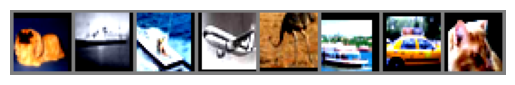

dog ship ship airplane bird ship automobile cat


In [3]:
# 데이터 확인
dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:8]))
print(' '.join(f'{classes[labels[j]]}' for j in range(8)))

In [4]:
# ResNet 모델 load
model = models.resnet18(weights=None)

In [5]:
model.conv1 = nn.Conv2d(
    in_channels=3,
    out_channels=64,
    kernel_size=3,
    stride=1,
    padding=1,
    bias=False
)
model.maxpool = nn.Identity()


num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


In [6]:
# 손실함수와 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    model.parameters(),
    lr=0.1,
    momentum=0.9,
    weight_decay=5e-4
)

scheduler = optim.lr_scheduler.MultiStepLR(
    optimizer,
    milestones=[60, 120],  # 에폭 몇에서 LR 줄일지
    gamma=0.2                   # 줄이는 비율
)

In [7]:
train_losses = []
test_accuracies = []

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

all_preds = []
all_labels = []


# 학습
EPOCHS = 150
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(trainloader)
    train_losses.append(epoch_loss)

    scheduler.step()

    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
      for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    test_acc = correct / total
    test_accuracies.append(test_acc)

    print(
        f"Epoch [{epoch+1}/{EPOCHS}] | "
        f"Loss: {epoch_loss:.4f} | "
        f"Test Acc: {test_acc*100:.2f}% | "
        f"LR: {optimizer.param_groups[0]['lr']:.6f}"
    )

Epoch [1/150] | Loss: 2.0169 | Test Acc: 41.17% | LR: 0.100000
Epoch [2/150] | Loss: 1.4734 | Test Acc: 48.40% | LR: 0.100000
Epoch [3/150] | Loss: 1.2240 | Test Acc: 58.47% | LR: 0.100000
Epoch [4/150] | Loss: 1.0183 | Test Acc: 66.59% | LR: 0.100000
Epoch [5/150] | Loss: 0.8550 | Test Acc: 71.38% | LR: 0.100000
Epoch [6/150] | Loss: 0.7299 | Test Acc: 75.24% | LR: 0.100000
Epoch [7/150] | Loss: 0.6440 | Test Acc: 76.71% | LR: 0.100000
Epoch [8/150] | Loss: 0.5861 | Test Acc: 78.72% | LR: 0.100000
Epoch [9/150] | Loss: 0.5460 | Test Acc: 78.12% | LR: 0.100000
Epoch [10/150] | Loss: 0.5169 | Test Acc: 76.86% | LR: 0.100000
Epoch [11/150] | Loss: 0.4944 | Test Acc: 80.18% | LR: 0.100000
Epoch [12/150] | Loss: 0.4830 | Test Acc: 77.87% | LR: 0.100000
Epoch [13/150] | Loss: 0.4649 | Test Acc: 76.90% | LR: 0.100000
Epoch [14/150] | Loss: 0.4472 | Test Acc: 79.57% | LR: 0.100000
Epoch [15/150] | Loss: 0.4365 | Test Acc: 81.53% | LR: 0.100000
Epoch [16/150] | Loss: 0.4277 | Test Acc: 81.57% 

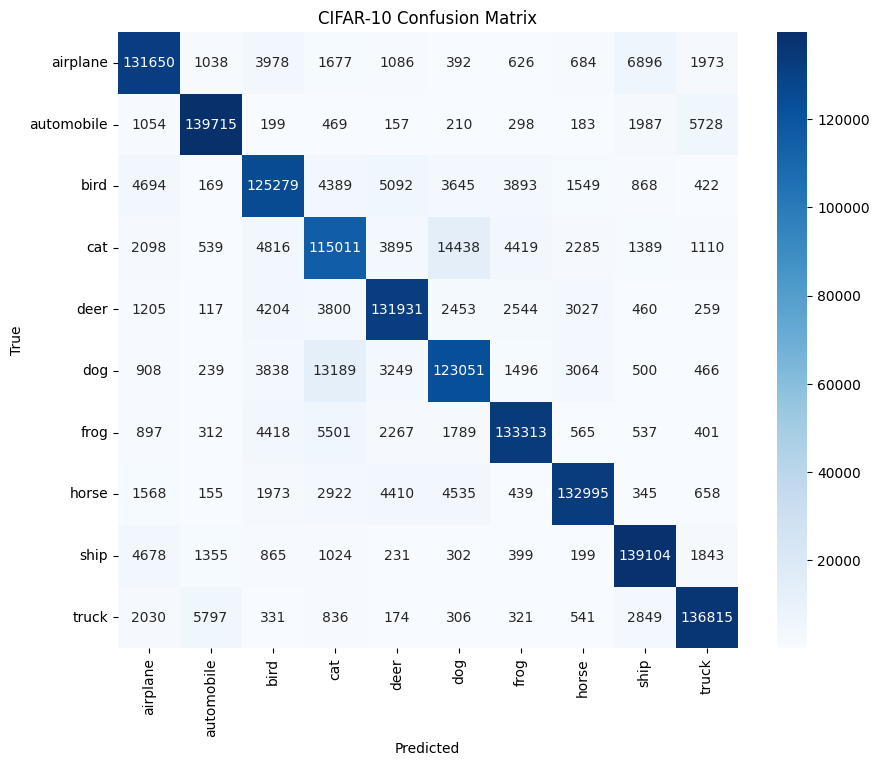

In [8]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=classes,
    yticklabels=classes
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("CIFAR-10 Confusion Matrix")
plt.show()


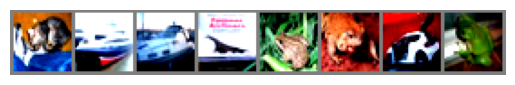

GroundTruth: cat ship ship airplane frog frog automobile frog
Predicted  : cat ship ship airplane frog frog automobile frog


In [9]:
# 예측 결과 시각화
dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, predicted = torch.max(outputs, 1)

imshow(torchvision.utils.make_grid(images[:8].cpu()))
print('GroundTruth:', ' '.join(classes[labels[j]] for j in range(8)))
print('Predicted  :', ' '.join(classes[predicted[j]] for j in range(8)))

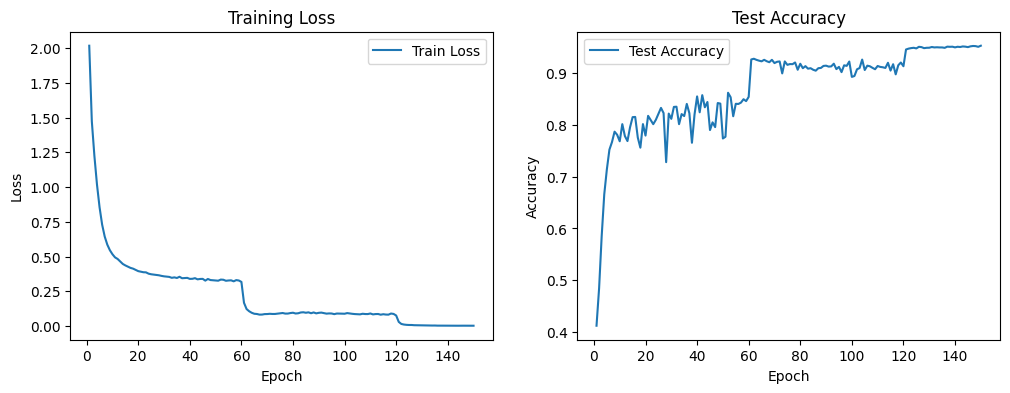

In [10]:
import matplotlib.pyplot as plt

epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, test_accuracies, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Test Accuracy")
plt.legend()

plt.show()
